### <center> **Análise Preditiva:** Música

**Objetivo:** Prever a música que será a mais escutada no próximo mês. Retornar também as top 5 músicas.

In [8]:
# Importações
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings


In [9]:
warnings.filterwarnings('ignore')

In [10]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('spotify_songs.csv')

### Compreensão dos Dados

In [11]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54615 entries, 0 to 54614
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 54615 non-null  object 
 1   platform                           54615 non-null  object 
 2   ms_played                          54615 non-null  int64  
 3   conn_country                       54615 non-null  object 
 4   ip_addr                            54615 non-null  object 
 5   master_metadata_track_name         54615 non-null  object 
 6   master_metadata_album_artist_name  54615 non-null  object 
 7   master_metadata_album_album_name   54583 non-null  object 
 8   spotify_track_uri                  54615 non-null  object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      flo

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2023-04-04 18:25:30+00:00,android,11451,BR,177.76.148.44,Talk that Talk,TWICE,BETWEEN 1&2,spotify:track:0RDqNCRBGrSegk16Avfzuq,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1.680633e+09,False,k-pop
1,2023-04-04 18:25:47+00:00,android,16559,BR,177.76.148.44,There's Nothing Holdin' Me Back,Shawn Mendes,Illuminate,spotify:track:7JJmb5XwzOO8jgpou264Ml,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1.680633e+09,False,pop
2,2023-04-04 18:25:55+00:00,android,4168,BR,177.76.148.44,Woman,Doja Cat,Planet Her,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1.680633e+09,False,pop
3,2023-04-04 19:23:17+00:00,android,80840,BR,177.76.148.44,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,clickrow,logout,False,False,False,1.680636e+09,False,k-pop
4,2023-04-04 22:51:39+00:00,android,67760,BR,201.42.207.140,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,appload,logout,False,False,False,1.680648e+09,False,k-pop


### Preparação de Dados

In [12]:
# Colunas necessárias: ts, ms_played, master_metadata_track_name, master_metadata_album_artist_name, shuffle, skipped

# Copiando os dados para outro df
df_music = df[['ts', 'ms_played', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'shuffle', 'skipped']].copy()

# apagando do df as músicas que foram puladas e estavam no modo aleatório
df_music = df_music[~((df_music['shuffle'] == True) & (df_music['skipped'] == True))]

# Convertendo para timestamp
df_music['ts'] = pd.to_datetime(df_music['ts'], format='ISO8601')

# Criando colunas de mês
df_music['mes'] = df_music['ts'].dt.to_period('M')

# Convertendo ms_played para minutos
df_music['min_played'] = df_music['ms_played'] / 60000

# df limpo
display(df_music.head())

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,shuffle,skipped,mes,min_played
0,2023-04-04 18:25:30+00:00,11451,Talk that Talk,TWICE,False,True,2023-04,0.190850
1,2023-04-04 18:25:47+00:00,16559,There's Nothing Holdin' Me Back,Shawn Mendes,False,True,2023-04,0.275983
2,2023-04-04 18:25:55+00:00,4168,Woman,Doja Cat,False,True,2023-04,0.069467
3,2023-04-04 19:23:17+00:00,80840,FLOWER,JISOO,False,False,2023-04,1.347333
4,2023-04-04 22:51:39+00:00,67760,FLOWER,JISOO,False,False,2023-04,1.129333


In [13]:
# Agregação mensal por música e artista
df_month = (
    df_music.groupby(['mes', 'master_metadata_track_name', 'master_metadata_album_artist_name'])
      ['min_played'].sum()
      .reset_index()
)

df_month['mes'] = df_month['mes'].dt.to_timestamp()
df_month = df_month.sort_values('mes')

# Preenche 0 nos meses que a música não foi ouvida
todos_meses = pd.date_range(
    start=df_month['mes'].min(),
    end=df_month['mes'].max(),
    freq='MS'
)
musicas_unicas = df_month[['master_metadata_track_name', 'master_metadata_album_artist_name']].drop_duplicates()
grade_completa = musicas_unicas.merge(
    pd.DataFrame({'mes': todos_meses}), how='cross'
)

df_month = grade_completa.merge(
    df_month,
    on=['master_metadata_track_name', 'master_metadata_album_artist_name', 'mes'],
    how='left'
).fillna({'min_played': 0})

# Criando variável temporal ordinal (numerando cada mês)
min_mes = df_month['mes'].min()
df_month['mes_ord'] = (
    (df_month['mes'].dt.year - min_mes.year) * 12 +
    (df_month['mes'].dt.month - min_mes.month) + 1
)

# Próximo mês a prever
ultimo_mes_ord = df_month['mes_ord'].max()
proximo_mes_ord = ultimo_mes_ord + 1

display(df_month.head())

# Mapeamento de mes_ord para label legível (como 'Jan/2024')
mes_map = (
    df_month[['mes_ord', 'mes']]
    .drop_duplicates()
    .set_index('mes_ord')['mes']
    .apply(lambda d: d.strftime('%b/%Y'))
)


,master_metadata_track_name,master_metadata_album_artist_name,mes,min_played,mes_ord
0,12,DEGE,2023-01-01,2.015983,1
1,12,DEGE,2023-02-01,4.031933,2
2,12,DEGE,2023-03-01,4.031950,3
3,12,DEGE,2023-04-01,6.047900,4
4,12,DEGE,2023-05-01,2.015967,5


### Modelo

In [14]:
resultados = []
avaliacoes = []

for musica in df_month['master_metadata_track_name'].unique():
    df_tmp = df_month[
        df_month['master_metadata_track_name'] == musica
    ][['mes_ord', 'min_played', 'master_metadata_album_artist_name']].copy()

    df_tmp = df_tmp.sort_values('mes_ord').dropna()

    # Pula músicas com histórico curto
    if len(df_tmp) < 3:
        continue

    artista = df_tmp['master_metadata_album_artist_name'].iloc[0]

    # Divisão de treino e teste
    n_test = 2
    train = df_tmp.iloc[:-n_test]
    test = df_tmp.iloc[-n_test:]

    X_train = train[['mes_ord']]
    y_train = train['min_played']
    X_test  = test[['mes_ord']]
    y_test  = test['min_played']

    # Modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Previsão do teste
    y_pred = model.predict(X_test)

    # Avaliação
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    avaliacoes.append({'musica': musica, 'artista': artista, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    # Previsão do próximo mês
    previsao = model.predict([[proximo_mes_ord]])[0]
    previsao = max(previsao, 0) 

    resultados.append({'musica': musica, 'artista': artista,'previsao_minutos': previsao})

print(f"Modelos treinados para {len(resultados)} músicas.")

Modelos treinados para 7082 músicas.


### Resultado das Avaliações

In [15]:
df_avaliacao = pd.DataFrame(avaliacoes).sort_values('MAE')
print("10 gêneros com menor erro de previsão (MAE):")
print(df_avaliacao.head(10).to_string(index=False))

10 gêneros com menor erro de previsão (MAE):
                                          musica              artista  MAE  RMSE  R2
                                       Two Vines    Empire Of The Sun  0.0   0.0 1.0
                         Ponta do Pé (Vem de Ré)             DJ Ryder  0.0   0.0 1.0
                                 There’s No Need    Empire Of The Sun  0.0   0.0 1.0
                           Nós Tá Por Aí - Remix DG e Batidão Stronda  0.0   0.0 1.0
                                     First Crush    Empire Of The Sun  0.0   0.0 1.0
                                   Vem Me Dengar        Rasta Chinela  0.0   0.0 1.0
                                            SLAY             EVERGLOW  0.0   0.0 1.0
Vira Cara pra Parede X Você Está em Paraisópolis               DJ BCH  0.0   0.0 1.0
                                   Ai Ai Ai Bebe          Menor Teteu  0.0   0.0 1.0
                                      Fact Check              NCT 127  0.0   0.0 1.0


### Resultado do Modelo (Previsão)

In [16]:
df_result = pd.DataFrame(resultados, columns=['musica', 'artista', 'previsao_minutos'])
top5 = df_result.sort_values('previsao_minutos', ascending=False).head(5)

musica = top5.iloc[0]['musica']
artista = top5.iloc[0]['artista']
minutos = top5.iloc[0]['previsao_minutos']

# Calcular o label do próximo mês a partir do último mês real
ultimo_mes_real = df_month['mes'].max()
proximo_mes_real = ultimo_mes_real + pd.DateOffset(months=1)
proximo_mes_label = proximo_mes_real.strftime('%B/%Y')

print(f"Próximo mês a prever: {proximo_mes_label}")
print(f"Música prevista para o próximo mês: '{musica}' — {artista}")
print(f"Previsão de minutos: {minutos:.2f} min\n")
print("5 músicas previstas:")
print(top5.to_string(index=False))

Próximo mês a prever: March/2026
Música prevista para o próximo mês: 'Apaguei Pra Todos - Ao Vivo' — Ferrugem
Previsão de minutos: 32.95 min

5 músicas previstas:
                     musica             artista  previsao_minutos
Apaguei Pra Todos - Ao Vivo            Ferrugem         32.950321
  Caso Indefinido - Ao Vivo    Cristiano Araújo         31.640034
Largado Às Traças - Ao Vivo Zé Neto & Cristiano         30.979138
           Domingo de Manhã    Marcos & Belutti         27.350042
              Maldita festa     Ana Laura Lopes         27.342461


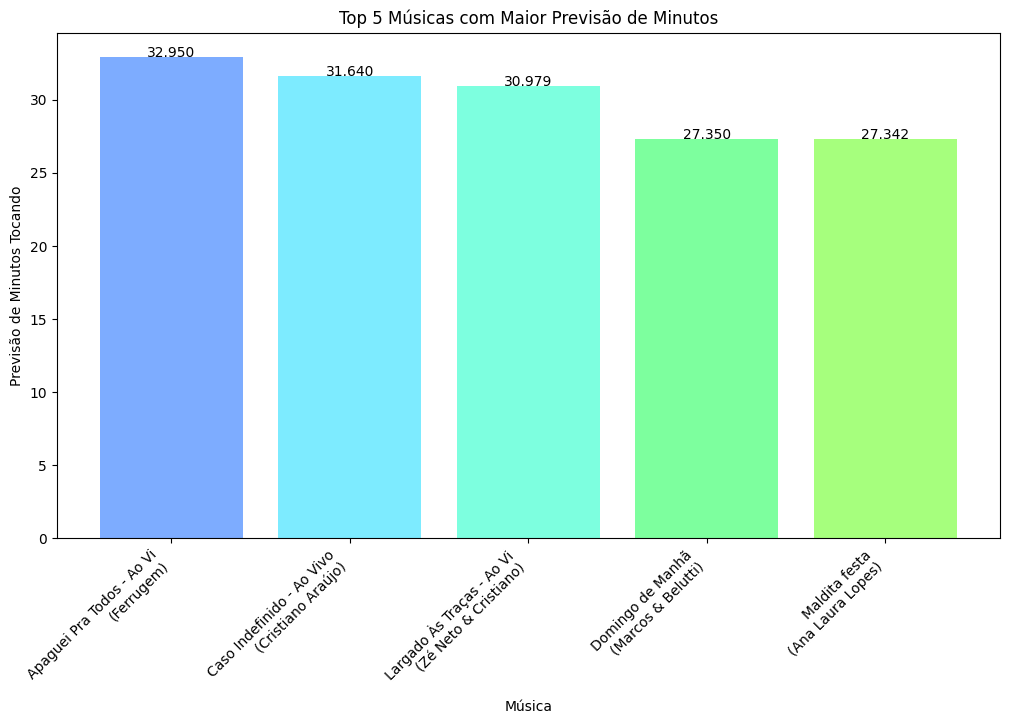

In [17]:
# Gráfico
plt.figure(figsize=(10, 6))

cores = ['#7DACFF', '#7DEBFF', '#7DFFDF', '#7DFF9E', '#A6FF7D']
labels = [f"{row['musica'][:25]}\n({row['artista'][:20]})" for _, row in top5.iterrows()]

plt.bar(labels, top5['previsao_minutos'], color=cores)
plt.title('Top 5 Músicas com Maior Previsão de Minutos')

for i, v in enumerate(top5['previsao_minutos']):
    plt.text(i, v, f"{v:.3f}", ha='center')

plt.tight_layout()

plt.xlabel('Música')
plt.ylabel('Previsão de Minutos Tocando')
plt.xticks(rotation=45, ha='right')
plt.show()

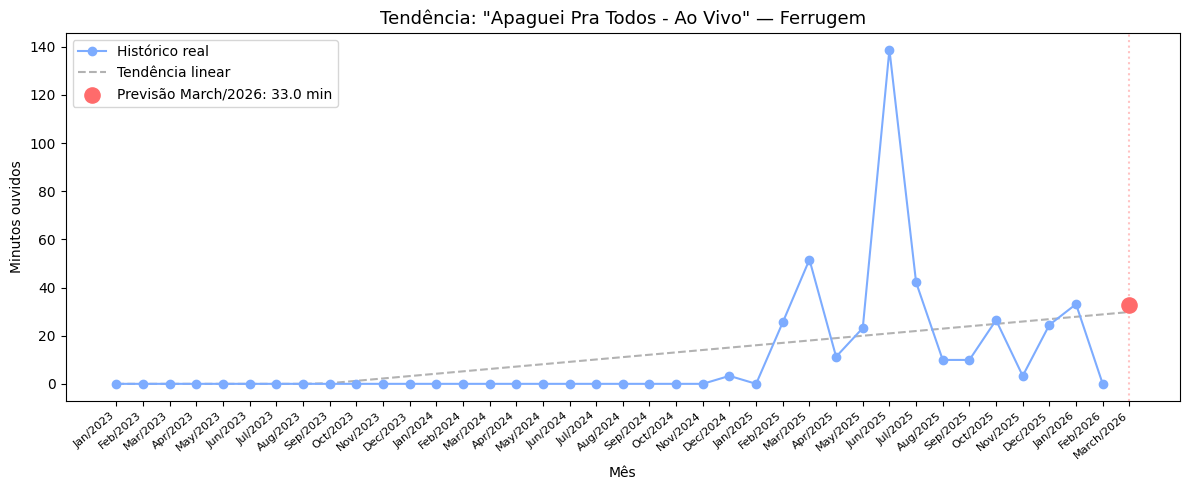

In [18]:
# Gráfico que mostra a tendência de minutos tocados do gênero previsto
df_v = (
    df_month[df_month['master_metadata_track_name'] == musica]
    [['mes_ord', 'mes', 'min_played']]
    .sort_values('mes_ord')
)

model_v = LinearRegression().fit(df_v[['mes_ord']], df_v['min_played'])

# Labels do eixo x: meses reais do histórico + próximo mês
x_ords   = list(df_v['mes_ord']) + [proximo_mes_ord]
x_labels = [mes_map.get(o, '') for o in df_v['mes_ord']] + [proximo_mes_label]

# Linha de tendência sobre todo o intervalo
x_range = np.arange(df_v['mes_ord'].min(), proximo_mes_ord + 1).reshape(-1, 1)
y_trend = np.clip(model_v.predict(x_range), 0, None)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_v['mes_ord'], df_v['min_played'], 'o-', label='Histórico real', color='#7DACFF', zorder=3)
ax.plot(x_range, y_trend, '--', label='Tendência linear', color='gray', alpha=0.6)
ax.scatter([proximo_mes_ord], [minutos], color='#FF6B6B', zorder=5, s=120,
           label=f'Previsão {proximo_mes_label}: {minutos:.1f} min')

# Eixo x com meses reais
ax.set_xticks(x_ords)
ax.set_xticklabels(x_labels, rotation=40, ha='right', fontsize=8)

# Linha pontilhada vertical destacando o ponto de previsão
ax.axvline(proximo_mes_ord, color='#FF6B6B', linestyle=':', alpha=0.4)

ax.set_title(f'Tendência: "{musica}" — {artista}', fontsize=13)
ax.set_xlabel('Mês')
ax.set_ylabel('Minutos ouvidos')
ax.legend()
plt.tight_layout()
plt.show()
